In [1]:
import torch
from NN_ANARX.ANARX import ANARX
import matplotlib.pyplot as plt
from tqdm import tqdm
from NN_ANARX.utilities import lag_matrix
import scipy.io



c:\Users\vh\Anaconda3\envs\PM\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# data loading and preparation
data = scipy.io.loadmat("data/1803")
input = data["u2_t"]
out = data["y_t"]

out = torch.Tensor(out).squeeze()
input = torch.Tensor(input).squeeze()
in_lagged = lag_matrix(input, 14)
out_lagged = lag_matrix(out, 5)

In [3]:
# create SISO-SANARX-Model
model = ANARX(14, [5], n_hidden=3, layersize= 10, afunc=torch.tanh, SANARX=True)

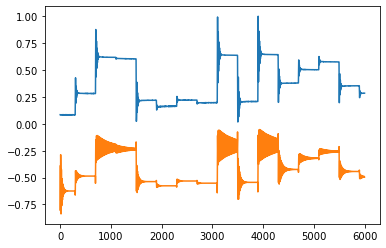

In [4]:
# Compare initial model prediction to real output
plt.plot(out.detach().numpy())
plt.plot(model.justpredict([input]).detach().numpy())

In [5]:
# Open Loop Training
optim = torch.optim.Adam(model.parameters())
crit = torch.nn.MSELoss()
dataset = torch.utils.data.TensorDataset(in_lagged, out_lagged, out)
loader = torch.utils.data.DataLoader(dataset, batch_size=20, shuffle=False)
for epoch in tqdm(range(20)):
    for i1, ol, os in loader:
        optim.zero_grad()
        result = model(ol, [i1])
        loss = crit(result, os)
        loss.backward()
        optim.step()

100%|██████████| 20/20 [00:57<00:00,  2.86s/it]


In [6]:
# Closed Loop Training
optim = torch.optim.Adam(model.parameters())
crit = torch.nn.MSELoss()
for i in tqdm(range(1)):
    optim.zero_grad()
    pred = model.predict([input])
    loss = crit(pred, out)
    loss.backward()
    optim.step()

100%|██████████| 1/1 [00:25<00:00, 25.70s/it]


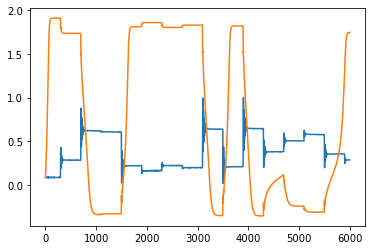

In [7]:
# Compare initial model prediction to real output
plt.plot(out.detach().numpy())
plt.plot(model.justpredict([input]).detach().numpy())

In [8]:
# save model
torch.save(model, "models/siso-model.pt")